In general, there are three types of model saving, a frozen model (.pb), a SavedModel (a folder containing .pb, assets and variables) and the checkpoint files (.ckpt). Here I used the SavedModel type as the demo and recommended using this type as the default exported type for future training or inference.


This tutorial is an introduction of saving or loading `SavedModels` in Tensorflow 2.x.

Accompanied by the release of Tensorflow 2.x, the SavedModel format was also updated. It replaced the older `Hub.Module` format for Tensorflow 1.x. But you can use the latest format in Tensorflow 1.15+. 

This tutorial you will see how to manipulate the older and the latest version of SavedModels with different APIs.

In [0]:
!pip install tensorflow==2.0.0

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.0.0


# Data Preprocessing

This section an image was downloaded and preprocessed for further uses. Two steps were involved in the preprocessing.
* First we resized an image to (224, 224) and then normalized each color channel of a pixel to a range between 0 and 1.
* Second we expanded the image Numpy array at the axis 0 to (1, 224, 224, 3). This step was prepared for batch training or inference.


In [0]:
def preprocess_image(img_path):
  img = cv2.imread(img_path)
  img = img[:,:,::-1]
  img = cv2.resize(img, (224,224))
  plt.imshow(img)
  plt.show()
  img = img / 255.0
  return img

In [12]:
!gsutil cp gs://jkw-gs/demo/VOC2012/JPEGImages/2007_000033.jpg ./
!ls -al

Copying gs://jkw-gs/demo/VOC2012/JPEGImages/2007_000033.jpg...
/ [1 files][ 69.5 KiB/ 69.5 KiB]                                                
Operation completed over 1 objects/69.5 KiB.                                     
total 22572
drwxr-xr-x 1 root root     4096 Dec 19 06:37 .
drwxr-xr-x 1 root root     4096 Dec 18 17:01 ..
-rw-r--r-- 1 root root    71205 Dec 19 06:37 2007_000033.jpg
drwxr-xr-x 1 root root     4096 Dec 13 16:39 .config
-rw-r--r-- 1 root root 23011066 Dec 19 06:30 imagenet_mobilenet_v2_140_224_classification_v4.tar.gz
drwxr-xr-t 4 root root     4096 Oct 17 10:09 mobilenet_new
drwxr-xr-x 1 root root     4096 Dec 12 16:48 sample_data


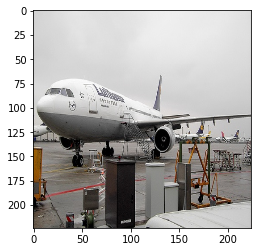

In [13]:
cls_img_path = "./2007_000033.jpg"
assert os.path.exists(cls_img_path), "Image was not found."

img = preprocess_image(cls_img_path)
img = np.expand_dims(img, axis=0)
assert img.shape == (1,224,224,3), "Image shape was not allowed."

## Data Labels

In [14]:
!curl https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt -o ImageNetLabels.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10484  100 10484    0     0  42967      0 --:--:-- --:--:-- --:--:-- 42967


In [15]:
labels = []
with open("./ImageNetLabels.txt") as fin:
  for line in fin:
    labels.append(line.strip())
print("Length of Labels: {}".format(len(labels)))

Length of Labels: 1001


# SavedModels

In this tutorial, a demo model was downloaded from `TF.hub` (https://tfhub.dev/). You can easily find and download the desired pre-trained models from the website.

The SavedModel is a flexible type of saving a model.  One feature is you can define the clear purpose for this model, for example, for `train` or for `serve` (default value). This can be added or signed while exporting a model. So the following script would possibly be not ready for every SavedModels you downloaded from TF.hub.

In [7]:
# this model was signed a tag `train`
!gsutil cp gs://jkw-gs/demo/tfhub/imagenet_mobilenet_v2_140_224_classification_v3.tar.gz ./
!rm -rf ./mobilenet
!mkdir ./mobilenet
!tar -xzf imagenet_mobilenet_v2_140_224_classification_v3.tar.gz -C mobilenet

Copying gs://jkw-gs/demo/tfhub/imagenet_mobilenet_v2_140_224_classification_v3.tar.gz...
\ [1 files][ 22.0 MiB/ 22.0 MiB]                                                
Operation completed over 1 objects/22.0 MiB.                                     


You can inspect the SavedModel which types were signed for this model via a command `saved_model_cli`.

In [9]:
!saved_model_cli show --dir ./mobilenet

The given SavedModel contains the following tag-sets:

train


In [10]:
!saved_model_cli show --dir ./mobilenet --tag_set train

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "default"
SignatureDef key: "image_classification"
SignatureDef key: "image_classification_with_bn_hparams"
SignatureDef key: "image_feature_vector"
SignatureDef key: "image_feature_vector_with_bn_hparams"


In [11]:
!saved_model_cli show --dir ./mobilenet --tag_set train --signature_def default

The given SavedModel SignatureDef contains the following input(s):
  inputs['images'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: hub_input/images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['default'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1001)
      name: MobilenetV2/Logits/output:0
Method name is: 


# Inference through tf.saved_model APIs

The first way to load a SavedModel is through `TF.saved_model` APIs. Here you must notice the parameter `tags` while loading the saved_model. If you assigned the tags with `train`, you asked the model for training and the inference you did would be different each time. An inference by default, the tag was assigned by `serve` or `(None)` (below).

In [12]:
saved_model_path = "./mobilenet"
assert os.path.exists(saved_model_path), "Saved model path was not found."

loaded = tf.saved_model.load(saved_model_path, tags=[])
print(list(loaded.signatures.keys()))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
['image_classification_with_bn_hparams', 'image_feature_vector_with_bn_hparams', 'default', 'image_classification', 'image_feature_vector']


Use `graph.get_operations()` to list all operations. This attribute is similar with Tensorflow 1.x.

In [13]:
all_ops = loaded.graph.get_operations()
for ops in all_ops[:10]:
    if ops.name[:4] == "save": continue
    print(ops.name)

hub_input/images
hub_input/Mul/y
hub_input/Mul
hub_input/Sub/y
hub_input/Sub
hub_hparams/batch_norm_momentum
MobilenetV2/input
MobilenetV2/Conv/weights/Initializer/truncated_normal/shape
MobilenetV2/Conv/weights/Initializer/truncated_normal/mean
MobilenetV2/Conv/weights/Initializer/truncated_normal/stddev


You can use the graph method `graph.get_tensor_by_name()` to get the operations. 

In [14]:
inputs = loaded.graph.get_tensor_by_name("hub_input/images:0")
outputs = loaded.graph.get_tensor_by_name("MobilenetV2/Logits/output:0")
print("Inputs: {}".format(inputs))
print("Outputs: {}".format(outputs))

Inputs: Tensor("hub_input/images:0", shape=(None, 224, 224, 3), dtype=float32)
Outputs: Tensor("MobilenetV2/Logits/output:0", shape=(None, 1001), dtype=float32)


Now you can assign a signature for different purposes. They had different input operations and output operations.

In [15]:
for sign in list(loaded.signatures.keys()):
  model = loaded.signatures[sign]
  model_inputs = model.inputs
  model_outputs = model.outputs
  print("Sign: {}".format(sign))
  print("  Inputs ({}):\n{}".format(len(model_inputs), model_inputs[:2]))
  print("  Outputs ({}):\n{}".format(len(model_outputs), model_outputs[:2]))
  print()

Sign: image_classification_with_bn_hparams
  Inputs (264):
[<tf.Tensor 'hub_hparams/batch_norm_momentum:0' shape=() dtype=float32>, <tf.Tensor 'hub_input/images:0' shape=(None, 224, 224, 3) dtype=float32>]
  Outputs (73):
[<tf.Tensor 'MobilenetV2/Logits/output:0' shape=(None, 1001) dtype=float32>, <tf.Tensor 'MobilenetV2/Predictions/Reshape_1:0' shape=(None, 1001) dtype=float32>]

Sign: image_feature_vector_with_bn_hparams
  Inputs (264):
[<tf.Tensor 'hub_input/images:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'hub_hparams/batch_norm_momentum:0' shape=() dtype=float32>]
  Outputs (73):
[<tf.Tensor 'MobilenetV2/Logits/output:0' shape=(None, 1001) dtype=float32>, <tf.Tensor 'MobilenetV2/Predictions/Reshape_1:0' shape=(None, 1001) dtype=float32>]

Sign: default
  Inputs (263):
[<tf.Tensor 'hub_input/images:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'MobilenetV2/Conv/weights:0' shape=() dtype=resource>]
  Outputs (1):
[<tf.Tensor 'MobilenetV2/Logits/output:0' shap

In [0]:
model = loaded.signatures["default"]

After running the commands below, you can easy to find the information about the keys of inputs and the keys of outputs.

You now can pass them as the variables into the model to do the inference.

In [31]:
!saved_model_cli show --dir ./mobilenet --tag_set train --signature_def default

The given SavedModel SignatureDef contains the following input(s):
  inputs['images'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: hub_input/images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['default'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1001)
      name: MobilenetV2/Logits/output:0
Method name is: 


In [32]:
img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

# pass the image tensor to the parameter `images`
result = model(images=img_tensor)

# get the result from the key `default`
cls = np.argmax(result["default"].numpy())

result, cls, labels[cls]

({'default': <tf.Tensor: id=10815, shape=(1, 1001), dtype=float32, numpy=
  array([[ 0.17250085, -0.68093574,  0.09629533, ..., -0.2762565 ,
           0.03316347, -0.07837074]], dtype=float32)>}, 405, 'airliner')

# Inference through hub.module

In [0]:
!pip install --upgrade tensorflow_hub

In [2]:
import tensorflow_hub as hub

print("TFHub Version: {}".format(hub.__version__))

TFHub Version: 0.7.0


In [2]:
module_spec = hub.load_module_spec("./mobilenet")

height, width = hub.get_expected_image_size(module_or_spec=module_spec)
print("Expected image size: height {}, width {}".format(height, width))

Expected image size: height 224, width 224


The following script would cause an error. The older format of a SavedModel can't be imported while the eager mode is active.

In [3]:
try:
  module = hub.Module(module_spec)
  module
except Exception as e:
  print("Error in loading an older version of SavedModel.\n{}".format(e))

Error in loading an older version of SavedModel.
Exporting/importing meta graphs is not supported when eager execution is enabled. No graph exists when eager execution is enabled.


The following a new SavedModel version was downloaded from TF.Hub.

In [1]:
# this model was signed a tag `train`
!gsutil cp gs://jkw-gs/demo/tfhub/imagenet_mobilenet_v2_140_224_classification_v4.tar.gz ./
!rm -rf ./mobilenet_new
!mkdir ./mobilenet_new
!tar -xzf imagenet_mobilenet_v2_140_224_classification_v4.tar.gz -C mobilenet_new

Copying gs://jkw-gs/demo/tfhub/imagenet_mobilenet_v2_140_224_classification_v4.tar.gz...
\ [1 files][ 22.0 MiB/ 22.0 MiB]                                                
Operation completed over 1 objects/22.0 MiB.                                     


In [2]:
!saved_model_cli show --dir ./mobilenet_new

The given SavedModel contains the following tag-sets:
serve


In [3]:
!saved_model_cli show --dir ./mobilenet_new --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"


In [4]:
!saved_model_cli show --dir ./mobilenet_new --tag_set serve --signature_def __saved_model_init_op

The given SavedModel SignatureDef contains the following input(s):
The given SavedModel SignatureDef contains the following output(s):
  outputs['__saved_model_init_op'] tensor_info:
      dtype: DT_INVALID
      shape: unknown_rank
      name: NoOp
Method name is: 


You can easily load the model via a `hub.KerasLayer` method.

In [0]:
m = hub.KerasLayer("./mobilenet_new")
m.build([None, 224, 224, 3])  # batch input shape

In [71]:
result = m(img)
cls = tf.argmax(result, axis=1)
print(cls, labels[cls.numpy()[0]], result.shape)

tf.Tensor([405], shape=(1,), dtype=int64) airliner (1, 1001)


You can also easily load the model as a layer of a bigger one constructed by a `tf.keras.Sequential` method. 

In [0]:
model = tf.keras.Sequential([
  hub.KerasLayer("./mobilenet_new")                          
])
model.build([None, 224, 224, 3])  # batch input shape

In [30]:
result = model(img)
cls = tf.argmax(result, axis=1)
print(cls, labels[cls.numpy()[0]])

tf.Tensor([405], shape=(1,), dtype=int64) airliner


# Retrain or Fine-tune a SavedModel

It is easy to build a bigger model via `tf.keras.Sequential`. It is simple to add `trainable=True` to the parameter of `hub.KerasLayer` method to do a fine-tune or a retrain task.


In [0]:
model_new = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4", trainable=True),
  tf.keras.layers.Dense(10, activation="relu")
])

You can simply start a training task with the Keras flow.

```python
# list the model architecture
model_new.summary()

# compile the model with the loss the the optimizer
model_new.compile(loss="categorical_crossentropy", 
                  optimizer="adam")

# start a training task
model_new.fit(image, label, batch_size=32)
```